[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)

# Imports

In [ ]:
! python --version

Python 3.7.13


In [ ]:
!pip install -q -U "tensorflow-text==2.8.*"
!pip install -q tf-models-official==2.4.0

     |████████████████████████████████| 4.9 MB 5.5 MB/s 
     |████████████████████████████████| 462 kB 66.3 MB/s 
     |████████████████████████████████| 1.1 MB 5.1 MB/s 
     |████████████████████████████████| 43 kB 1.6 MB/s 
     |████████████████████████████████| 1.1 MB 49.2 MB/s 
     |████████████████████████████████| 237 kB 53.9 MB/s 
     |████████████████████████████████| 1.2 MB 51.6 MB/s 
     |████████████████████████████████| 47.8 MB 107 kB/s 
     |████████████████████████████████| 352 kB 72.5 MB/s 
     |████████████████████████████████| 596 kB 74.4 MB/s 
     |████████████████████████████████| 99 kB 12.6 MB/s 


In [ ]:
!pip install tensorflow_hub
!pip install keras pydot graphviz

In [ ]:
import os

import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub

from keras.utils import np_utils

import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization as tokenization

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

1 Physical GPUs, 1 Logical GPUs
Version:  2.8.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


# Data

# New Section

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/MIAR/TFM/BERT Sentiment/data/IMDB Dataset.csv',
                 encoding='ISO-8859-1', 
                 )

In [ ]:
pd.set_option('max_colwidth', 100)

In [ ]:
df.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked....,positive
1,A wonderful little production. <br /><br />The filming technique is very unassuming- very old-ti...,positive
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air...",positive
3,Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei off...",positive
5,"Probably my all-time favorite movie, a story of selflessness, sacrifice and dedication to a nobl...",positive
6,I sure would like to see a resurrection of a up dated Seahunt series with the tech they have tod...,positive
7,"This show was an amazing, fresh & innovative idea in the 70's when it first aired. The first 7 o...",negative
8,Encouraged by the positive comments about this film on here I was looking forward to watching th...,negative
9,If you like original gut wrenching laughter you will like this movie. If you are young or old th...,positive


We have two classes in the dataset

In [ ]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


positive    25000
negative    25000
Name: sentiment, dtype: int64

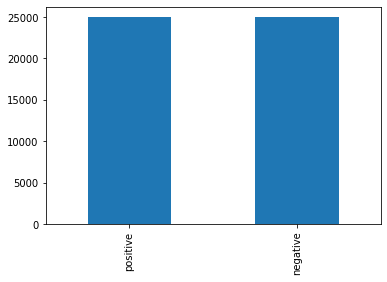

In [ ]:
df['sentiment'].value_counts().plot(kind='bar')
df['sentiment'].value_counts()

In [ ]:
pd.concat(g for _, g in df.groupby("review") if len(g) > 1)

,review,sentiment
34058,"""Go Fish"" garnered Rose Troche rightly or wrongly the reputation of a film maker with much promi...",negative
47467,"""Go Fish"" garnered Rose Troche rightly or wrongly the reputation of a film maker with much promi...",negative
29956,"""Three"" is a seriously dumb shipwreck movie. Masquerading as a psychological thriller, it's clos...",negative
31488,"""Three"" is a seriously dumb shipwreck movie. Masquerading as a psychological thriller, it's clos...",negative
2976,"""Witchery"" might just be the most incoherent and lamentably scripted horror movie of the 80's bu...",negative
...,...,...
47876,this movie sucks. did anyone notice that the entire movie was shot in like 2 rooms. there are NE...,negative
23056,"well, the writing was very sloppy, the directing was sloppier, and the editing made it worse (at...",negative
44122,"well, the writing was very sloppy, the directing was sloppier, and the editing made it worse (at...",negative
10163,"when I first heard about this movie, I noticed it was one of the most controversial films of the...",positive


In [ ]:
df = df.drop_duplicates()

In [ ]:
#sentiment count
df['sentiment'].value_counts()

positive    24884
negative    24698
Name: sentiment, dtype: int64

In [ ]:
from bs4 import BeautifulSoup
import re, string

In [ ]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
df.sentiment.unique()

array(['positive', 'negative'], dtype=object)

In [ ]:
#Eliminando etiquetas HTML
def remove_html_tags(text):
    return re.sub('<.*?>', '', text)

#Eliminando textos entre corchetes
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Eliminando signos de puntuación
def remove_string_punctuation(text):
    text = text.translate(text.maketrans('', '', string.punctuation))
    return text

#Funcion de limpieza
def denoise_text(text):
    text = remove_html_tags(text)
    text = remove_between_square_brackets(text)
    text = remove_string_punctuation(text)
    return text

#Aplicando la función de limpieza al dataframe
df['review']=df['review'].apply(denoise_text)

In [ ]:
df['review'][4]

'Petter Matteis Love in the Time of Money is a visually stunning film to watch Mr Mattei offers us a vivid portrait about human relations This is a movie that seems to be telling us what money power and success do to people in the different situations we encounter This being a variation on the Arthur Schnitzlers play about the same theme the director transfers the action to the present time New York where all these different characters meet and connect Each one is connected in one way or another to the next person but no one seems to know the previous point of contact Stylishly the film has a sophisticated luxurious look We are taken to see how these people live and the world they live in their own habitatThe only thing one gets out of all these souls in the picture is the different stages of loneliness each one inhabits A big city is not exactly the best place in which human relations find sincere fulfillment as one discerns is the case with most of the people we encounterThe acting i

Let's check how equally distributed those classes are.

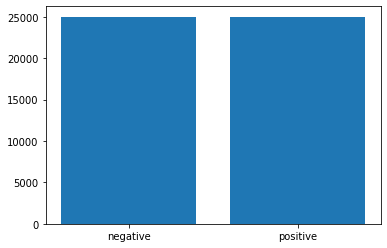

In [ ]:
classes = df.sentiment.unique()
counts = []

for i in classes:
  count = len(df[df.sentiment==i])
  counts.append(count)

plt.bar(['negative', 'positive'], counts)
plt.show()

Even class distribution helps us a lot in text classifiction. Imagine a situation where 95% of data is in one class and the rest 5% is split among other 5 classes. If we wouldn't do anything about it model would just learn to guess the 95% class all the time and would be correct 95% of the time on the data we would use.

To start modelling we still need to do a couple of things:

1.   Split data into train and test datasets
2.   Encode labels
3.   Tokenize text



## Train/test split

We don't really need all 1.6 Million tweets for training so we can take a sample of 5% (to save up time on training) and then split that into 80% for training and 20% for testing.

In [ ]:
sample_size = int(len(df)*0.05)
sampleDf = df.sample(sample_size, random_state=42)
x = sampleDf.review.values
y = sampleDf.sentiment.values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

In [ ]:
##
unique, counts = np.unique(y, return_counts=True)

result = np.column_stack((unique, counts)) 
print (result)

[['negative' 1239]
 ['positive' 1261]]


## Label Encoding

We could get away with other approach but you might want to use this for more than binary classification.

In [ ]:
encoder = LabelEncoder()
encoder.fit(y)
encoded_Y_test = encoder.transform(y_test)
encoded_Y_train = encoder.transform(y_train)

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_test = np_utils.to_categorical(encoded_Y_test)
dummy_y_train = np_utils.to_categorical(encoded_Y_train)

In [ ]:
##
print(len(encoded_Y_train))
print(dummy_y_train.shape)
print(dummy_y_train)

2000
(2000, 2)
[[0. 1.]
 [0. 1.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]]


We might want to use encoding for later. For that we can save enconding map.

In [ ]:
encoder_fname = 'imdb_classes.npy'
my_wd = '/content/gdrive/MyDrive/MIAR/TFM/BERT Sentiment/data/'
np.save(os.path.join(my_wd, encoder_fname) , encoder.classes_)

To load it when you'll use this in production just use the below cell (uncommented ofcourse)

In [ ]:
# encoder = LabelEncoder()
# encoder.classes_ = np.load(os.path.join(my_wd, encoder_fname), allow_pickle=True)

## Tokenization

To tokenize our text we will use some functions from official.nlp.bert package and the pretrained [BERT](https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270) model itself. \\
First we get the BERT model. I'll use the multilingual one as it will be best for most of your cases. To check all NLP models provided by TF HUB go [here](https://tfhub.dev/s?module-type=text-embedding,text-classification,text-generation,text-language-model,text-question-answering,text-retrieval-question-answering).

In [ ]:
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/2",
                            trainable=True)

In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

You can see that in above cell we have loaded some variables using the bert_layer we have downloaded. 

1.   ```vocab_file``` reads the vocab file associated to the downloaded model.
2.   ```do_lower_case``` reads binary variable which if ```True``` means tokenizer will reformat all text to lower case rendering model to be **NOT** case sensitive. Should be ```False``` by default. You can check in a cell below.
3.   ```tokenizer``` builds tokenizer using variables 1 and 2.



In [ ]:
do_lower_case

False

In [ ]:
##
tokenizer.tokenize('Hello how are your printer?')

['Hello', 'how', 'are', 'your', 'print', '##er', '?']

Lastly we need to add two additional tokens: Classification and Seperation. We will add these through functions we will use to tokenize our text.

In [ ]:
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])

[101, 102]

Kewl, by this point we have everything for tokenization. This will take a bit as we have quite a bit of data.

In [ ]:
def encode_names(n):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')  # seperation token. Would bemuch more useful if you had a multiple text input.
   return tokenizer.convert_tokens_to_ids(tokens)

reviews = tf.ragged.constant([
    encode_names(n) for n in x_train])

In [ ]:
print('Tokenized Reviews shape', reviews.shape.as_list())

Tokenized Reviews shape [2000, None]


This is to what our tweets have converted to. The ids there are essentially the same as in the simple NN example we did last time, just this time we use a predefined vocabulary.


In [ ]:
reviews[10]

<tf.Tensor: shape=(315,), dtype=int32, numpy=
array([ 10882,    169,  10862,  10108,  16040,  35841,  10251,    139,
          119,    146,    119,    144,    119,    117,    146,  10134,
        34279,  23307,  10114,  10531,  18379,    119,    146,  10392,
        10119,  23044,  14212,  10216,  10114,  12888,  10271,  10124,
          169,  70032,  18379,    119,  94304,  79913,  10124,  10472,
        10173,  15478,  19113,  10345,  13486,  29025,  21408,  10114,
        16874,  23432,  16040,  35841,  10251,    139,    119,    146,
          119,    144,    119,    138,  19826,  10108,  10105,  13617,
        23698,  16040,  35841,  10251,    139,    119,    146,    119,
          144,    119,    112,    187,  13486,  10312,    117,  15244,
        16366,  22156,  10146,  16040,  35841,  10251,    139,    119,
          146,    119,    144,    119,  10146,    169,  10879,  10162,
          119, 109320,    117,  10261,  10124,  10472,  10173,  15478,
        19113,  21408,  10114, 

If you want to see how tokenizer does the "tokenizing" check the cells below.

In [ ]:
x_train[0]

'It\'s a little disconcerting to have a character named Gig Young in a movie...played by Gig Young. But this film is where Gig got his name and also a nice career boost after playing small parts under another name.<br /><br />I\'m going to go against the majority of the other comments and state that I really enjoyed this film, mainly because of the vibrant performance of Barbara Stanwyck as Fiona. She was funny, angry, vulnerable, caring, and feisty as the oldest of three daughters whose mother died on the Lusitania, and whose father was later killed during Woar War I. <br /><br />As the "man" of the house, Fiona has stood steadfast for years against settling her father\'s will which would therefore allow a Donald Trump type named Charles Barclay to get the family home. But Fiona\'s keeping a secret as to why she hates Barclay so much. Geraldine Fitzgerald is the middle, flirty sister, who is married to an Englishman but craves her youngest sister\'s boyfriend (Gig Young).<br /><br />I

In [ ]:
tokenizedReview = tokenizer.tokenize(x_train[0])
for i in tokenizedReview:
  print(i, tokenizer.convert_tokens_to_ids([i]))

It [10377]
' [112]
s [187]
a [169]
little [16745]
disco [14884]
##nce [12150]
##rti [28304]
##ng [10376]
to [10114]
have [10529]
a [169]
character [15092]
named [12038]
G [144]
##ig [11142]
Young [12478]
in [10106]
a [169]
movie [18379]
. [119]
. [119]
. [119]
played [11553]
by [10155]
G [144]
##ig [11142]
Young [12478]
. [119]
But [16976]
this [10531]
film [10458]
is [10124]
where [10940]
G [144]
##ig [11142]
got [19556]
his [10226]
name [11324]
and [10111]
also [10379]
a [169]
nic [46267]
##e [10112]
career [13021]
bo [20506]
##ost [18239]
after [10662]
playing [14879]
small [12474]
parts [15569]
under [10571]
another [12864]
name [11324]
. [119]
< [133]
br [33989]
/ [120]
> [135]
< [133]
br [33989]
/ [120]
> [135]
I [146]
' [112]
m [181]
going [19090]
to [10114]
go [11783]
against [11327]
the [10105]
majority [19471]
of [10108]
the [10105]
other [10684]
comments [61565]
and [10111]
state [11388]
that [10189]
I [146]
really [30181]
enjoyed [52072]
this [10531]
film [10458]
, [117]
ma

We still need to add classification token.

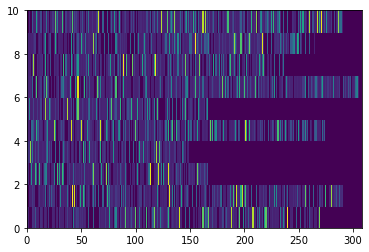

In [ ]:
cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*reviews.shape[0]
input_word_ids = tf.concat([cls, reviews], axis=-1)
_ = plt.pcolormesh(input_word_ids[0:10].to_tensor())

In [ ]:
##
print(input_word_ids[0:3].to_tensor())

tf.Tensor(
[[   101  10377    112    187    169  16745  14884  12150  28304  10376
   10114  10529    169  15092  12038    144  11142  12478  10106    169
   18379    119    119    119  11553  10155    144  11142  12478    119
   16976  10531  10458  10124  10940    144  11142  19556  10226  11324
   10111  10379    169  46267  10112  13021  20506  18239  10662  14879
   12474  15569  10571  12864  11324    119    133  33989    120    135
     133  33989    120    135    146    112    181  19090  10114  11783
   11327  10105  19471  10108  10105  10684  61565  10111  11388  10189
     146  30181  52072  10531  10458    117  20827  12373  10108  10105
   13956  81371  10123  14432  10108  16010  26637  12524  11263  10146
   82503    119  11149  10134  41807  10756    117  10488  10908    117
   75602    117  13000  10230    117  10111  34778  87706  10146  10105
   27626  10108  11003  43392  16879  15293  12482  10135  10105  23859
   69999  11335    117  10111  16879  13194  10134  1

What you see above is a graphical representation of our tokenized tweets. First token is our classification token. Other colored blocks than background are other tokens. And background, well that's just padding.

## Mask and input type

The model expects two additional inputs:

* The input mask
* The input type

The mask allows the model to cleanly differentiate between the content and the padding. The mask has the same shape as the `input_word_ids`, and contains a `1` anywhere the `input_word_ids` is not padding.

In [ ]:
input_word_ids

<tf.RaggedTensor [[101, 10377, 112, 187, 169, 16745, 14884, 12150, 28304, 10376, 10114,
  10529, 169, 15092, 12038, 144, 11142, 12478, 10106, 169, 18379, 119, 119,
  119, 11553, 10155, 144, 11142, 12478, 119, 16976, 10531, 10458, 10124,
  10940, 144, 11142, 19556, 10226, 11324, 10111, 10379, 169, 46267, 10112,
  13021, 20506, 18239, 10662, 14879, 12474, 15569, 10571, 12864, 11324, 119,
  133, 33989, 120, 135, 133, 33989, 120, 135, 146, 112, 181, 19090, 10114,
  11783, 11327, 10105, 19471, 10108, 10105, 10684, 61565, 10111, 11388,
  10189, 146, 30181, 52072, 10531, 10458, 117, 20827, 12373, 10108, 10105,
  13956, 81371, 10123, 14432, 10108, 16010, 26637, 12524, 11263, 10146,
  82503, 119, 11149, 10134, 41807, 10756, 117, 10488, 10908, 117, 75602,
  117, 13000, 10230, 117, 10111, 34778, 87706, 10146, 10105, 27626, 10108,
  11003, 43392, 16879, 15293, 12482, 10135, 10105, 23859, 69999, 11335, 117,
  10111, 16879, 13194, 10134, 10873, 15875, 10939, 102204, 10354, 11277,
  146, 119, 133, 33

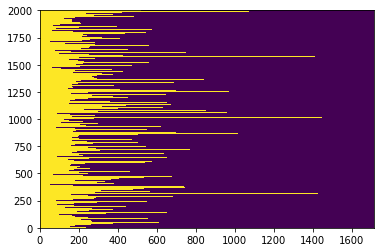

In [ ]:
input_mask = tf.ones_like(input_word_ids).to_tensor()

plt.pcolormesh(input_mask)

Here each yellow block has some input. We just make this for the model to differ between padding and input.

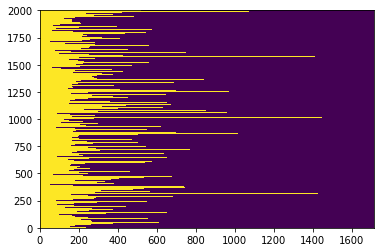

In [ ]:
type_cls = tf.zeros_like(cls)
type_review = tf.ones_like(reviews)
input_type_ids = tf.concat([type_cls, type_review], axis=-1).to_tensor()

plt.pcolormesh(input_type_ids)

In [ ]:
##
input_type_ids


<tf.Tensor: shape=(2000, 1716), dtype=int32, numpy=
array([[0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0]], dtype=int32)>

It's hard to see but we added an empty block in front of each tweet for the `[CLS]` token. Check tensor below

In [ ]:
input_type_ids

<tf.Tensor: shape=(2000, 1716), dtype=int32, numpy=
array([[0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0]], dtype=int32)>

## Remake into a function for normal use

So at this point we have all of our three inputs:

1.   Tokens
2.   Input mask
3.   Input type

It will make our work easier both now and in the future if we remake everything into funcitons.



First let's set the max sequence lenght as we did in simple NN example.

In [ ]:
lens = [len(i) for i in input_word_ids]

In [ ]:
##
lens

[272,
 293,
 169,
 152,
 278,
 169,
 308,
 241,
 267,
 293,
 316,
 247,
 175,
 95,
 302,
 1341,
 158,
 217,
 712,
 481,
 297,
 101,
 550,
 207,
 140,
 184,
 527,
 613,
 167,
 231,
 670,
 191,
 320,
 359,
 266,
 170,
 134,
 594,
 74,
 190,
 1168,
 76,
 413,
 206,
 377,
 322,
 410,
 325,
 637,
 173,
 359,
 92,
 417,
 617,
 380,
 582,
 149,
 174,
 161,
 185,
 952,
 190,
 269,
 115,
 413,
 79,
 426,
 145,
 100,
 493,
 204,
 266,
 168,
 203,
 217,
 268,
 252,
 365,
 201,
 190,
 214,
 316,
 337,
 270,
 342,
 168,
 212,
 337,
 65,
 97,
 560,
 157,
 558,
 440,
 174,
 148,
 257,
 103,
 390,
 252,
 1205,
 320,
 100,
 420,
 159,
 271,
 217,
 300,
 184,
 1082,
 252,
 169,
 856,
 647,
 465,
 484,
 217,
 169,
 458,
 723,
 1141,
 160,
 167,
 371,
 379,
 741,
 104,
 207,
 257,
 398,
 276,
 304,
 344,
 245,
 160,
 125,
 344,
 58,
 203,
 205,
 224,
 147,
 181,
 182,
 100,
 658,
 333,
 339,
 571,
 170,
 686,
 251,
 417,
 294,
 192,
 136,
 776,
 181,
 271,
 186,
 156,
 563,
 153,
 254,
 272,
 241,
 75,
 2

In [ ]:
max_seq_length = max(lens)
print('Max length is:', max_seq_length)

Max length is: 1716


Most of the time I suggest adding a bit more to the `max_seq_length` esspecially when ussing just a fraction of data. Let's make it `1.5*max_seq_length`.

In [ ]:
#max_seq_length = int(1.5*max_seq_length)
max_seq_length = 512
print('Max length is:', max_seq_length)

Max length is: 512


Functions themselves.

In [ ]:
def encode_names(n, tokenizer):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(string_list, tokenizer, max_seq_length):
  num_examples = len(string_list)
  
  string_tokens = tf.ragged.constant([
      encode_names(n, tokenizer) for n in np.array(string_list)])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*string_tokens.shape[0]
  input_word_ids = tf.concat([cls, string_tokens], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor(shape=(None, max_seq_length))

  type_cls = tf.zeros_like(cls)
  type_tokens = tf.ones_like(string_tokens)
  input_type_ids = tf.concat(
      [type_cls, type_tokens], axis=-1).to_tensor(shape=(None, max_seq_length))

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(shape=(None, max_seq_length)),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

And now we preprocess inputs.

In [ ]:
X_train = bert_encode(x_train, tokenizer, max_seq_length)
X_test = bert_encode(x_test, tokenizer, max_seq_length)

# Bam MODEL part already

## Initial training

We need to set up our model using the inputs we made, BERT model that we downloaded and an output layer based on num of classes we are using.

In [ ]:
num_class = len(encoder.classes_)  # Based on available class selection
max_seq_length = max_seq_length  # we calculated this a couple cells ago

input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="segment_ids")

pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])                                  

output = tf.keras.layers.Dropout(rate=0.1)(pooled_output)

output = tf.keras.layers.Dense(num_class, activation='softmax', name='output')(output)

model = tf.keras.Model(
    inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
        },
        outputs=output)

In [ ]:
[input_word_ids, input_mask, segment_ids]

[<KerasTensor: shape=(None, 512) dtype=int32 (created by layer 'input_word_ids')>,
 <KerasTensor: shape=(None, 512) dtype=int32 (created by layer 'input_mask')>,
 <KerasTensor: shape=(None, 512) dtype=int32 (created by layer 'segment_ids')>]

Our model.

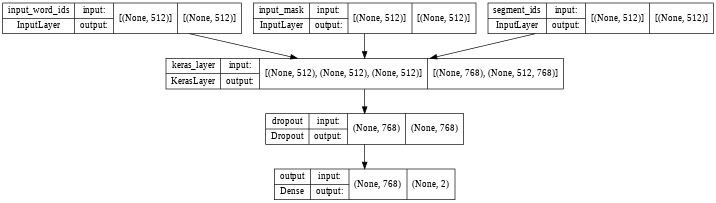

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=48)

Set up the training parameters.

In [ ]:
epochs = 3
batch_size = 8  # select based on your GPU resources
eval_batch_size = batch_size

train_data_size = len(dummy_y_train)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

Compile the model.

In [ ]:
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 512)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 512)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        177853441   ['input_word_ids[0][0]',         
                                 (None, 512, 768)]                'input_mask[0][0]',         

Set up a history to check our model performance afterwards.

In [ ]:
dummy_y_test


array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.

In [ ]:
history = model.fit(X_train,
                    dummy_y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_test, dummy_y_test),
                    verbose=1)

Epoch 1/3
250/250 [==============================] - 182s 685ms/step - loss: 0.5956 - accuracy: 0.6600 - val_loss: 0.3523 - val_accuracy: 0.8500
Epoch 2/3
250/250 [==============================] - 170s 682ms/step - loss: 0.3235 - accuracy: 0.8835 - val_loss: 0.4296 - val_accuracy: 0.8700
Epoch 3/3
250/250 [==============================] - 170s 682ms/step - loss: 0.2588 - accuracy: 0.9075 - val_loss: 0.4296 - val_accuracy: 0.8700


Evaluation

In [ ]:
loss, accuracy = model.evaluate(X_train, dummy_y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, dummy_y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9170
Testing Accuracy:  0.8700


Noice plots are noice

In [ ]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

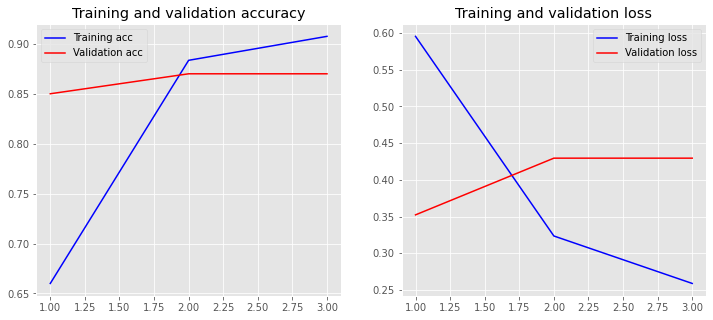

In [ ]:
plot_history(history)

So, looking at the plot above we can see that at the 3rd epoch our `Validation Loss` jumped significantly even though `Validation Accuracy` stayed pretty much the same. If we would train it more on the same data it would significantly overtrain. \\
What we can do instead is make another training dataset, lower our learning rate commonly denoted as `lr`, recompile our model using new `lr` and then train it a bit more. \\
But before doing that we should save our model just in case if we would want to do the additional training in later sessions.

## Model saving for later use

Let's save our model for later use. Unfortunatelly we can't use the optimizer we used for model training to save. I get an error and I can't resolve it. So we will recompile our model before saving.

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model_fname = 'imdb_BERT_5pct'
my_wd = '/content/gdrive/MyDrive/MIAR/TFM/BERT Sentiment/data/'

model.save(os.path.join(my_wd, model_fname))

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/MIAR/TFM/BERT Sentiment/data/imdb_BERT_5pct/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/MIAR/TFM/BERT Sentiment/data/imdb_BERT_5pct/assets


### Validate saved model

Sometimes TF likes to corrupt your model when saving. It's always a good idea to check if everything loads correctly after save.

In [ ]:
model_fname = 'imdb_BERT_5pct'
my_wd = '/content/gdrive/MyDrive/MIAR/TFM/BERT Sentiment/data/'

new_model = tf.keras.models.load_model(os.path.join(my_wd, model_fname))

In [ ]:
loss, accuracy = new_model.evaluate(X_test, dummy_y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Testing Accuracy:  0.8282


In [ ]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 180)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 180)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 180)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        177853441   ['input_word_ids[0][0]',         
                                 (None, 180, 768)]                'input_mask[0][0]',         

For safety reasons I would check the tokenizer variables as well.

In [ ]:
tokenizerSaved = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(my_wd, model_fname, 'assets/vocab.txt'),
    do_lower_case=False)

If this loads, you should be fine.

In [ ]:
tokenizedTweet = tokenizerSaved.tokenize(x_train[0])
for i in tokenizedTweet:
  print(i, tokenizerSaved.convert_tokens_to_ids([i]))

im [10211]
soo [101893]
ob [17339]
##ses [13149]
##sed [16219]
with [10169]
the [10105]
song [12011]
& [111]
quo [48718]
##t [10123]
; [132]
when [10841]
i [177]
get [15329]
home [11816]
your [20442]
so [10380]
dead [23457]
by [10155]
may [11387]
##day [24558]
parade [71115]
& [111]
quo [48718]
##t [10123]
; [132]
it [10271]
an [10151]
aw [56237]
##some [79972]
song [12011]
! [106]


As everything seems fine, we can move on to second training itteration and try to make our model a bit better.

## Second training itteration

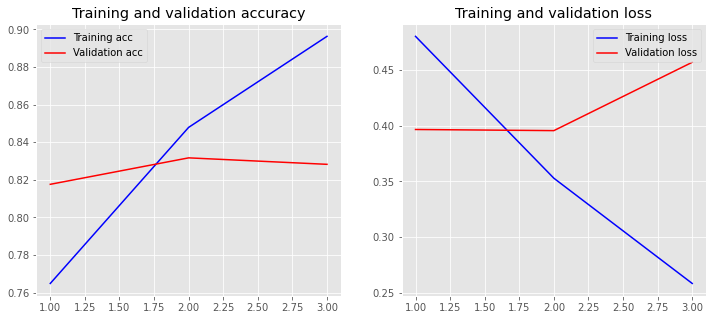

In [ ]:
plot_history(history)

As mentioned before, looking at the plot above we can see that at the 3rd epoch our `Validation Loss` jumped significantly even though `Validation Accuracy` stayed pretty much the same. If we would train it more on the same data it would significantly overtrain. \\

What we can do instead is make another training dataset, lower our learning rate commonly denoted as `lr`, recompile our model using new `lr` and then train it a bit more.

Are there any other options to approach overtraining? Sure. One of the most obvious ways would be to increase dropout layer number or the dropout precentage. You could try playing around with pooling as well, but in essence dropout would be your go to. 

If you do not know what dropout is then in short it 'turns off' preceeding layer neurons before next layer calculation, thus increasing the need for the model to 'abstract' things it sees.

Anyway, in our case we are doing `lr` change and adding new data for the model. Let's see how that goes.

### Data

First we need to prep our data. It's good that we made our processing easier making some functions. Let's take another 5% sample from our data.

In [ ]:
sample_size = int(len(df)*0.05)
sampleDf = df.sample(sample_size, random_state=42)  # notice the random state changes
x = sampleDf.text.values
y = sampleDf.target.values
x_train2, x_test2, y_train2, y_test2 = train_test_split(x, y, test_size=0.20, random_state=19)  # notice the random state changes

[0 4]


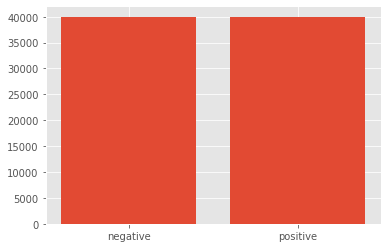

In [ ]:
classes = sampleDf.target.unique()
print(classes)
counts = []

for i in classes:
  count = len(sampleDf[sampleDf.target==i])
  counts.append(count)

plt.bar(['negative', 'positive'], counts)
plt.show()

It's not a bad idea to always check if your sample is representitive of the dataset itself. Most of the time it will, but when getting small samples it might be off in small datasets.

#### Label Encoding
Now we need to encode labels again. Good thing we have our label encoder saved.

In [ ]:
encoder_fname = 'twitter_classes.npy'
my_wd = '/content/gdrive/MyDrive/MIAR/TFM/BERT Sentiment/data/'

encoder = LabelEncoder()
encoder.classes_ = np.load(os.path.join(my_wd, encoder_fname), allow_pickle=True)

encoded_Y_test2 = encoder.transform(y_test2)
encoded_Y_train2 = encoder.transform(y_train2)

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_test2 = np_utils.to_categorical(encoded_Y_test2)
dummy_y_train2 = np_utils.to_categorical(encoded_Y_train2)

#### Input preprocessing
As we did before we need to tokenize our inputs (tweets) as `input_word_ids` and then add `input_mask` and `input_type`. As we saved our model, we can use it to build our tokenizer as it was.

In [ ]:
model_fname = 'imdb_BERT_5pct'
my_wd = '/content/gdrive/MyDrive/MIAR/TFM/BERT Sentiment/data/'

tokenizerSaved = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(my_wd, model_fname, 'assets/vocab.txt'),
    do_lower_case=False)

I repaste our encoding functions here so it would be easier to follow.

In [ ]:
def encode_names(n, tokenizer):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(string_list, tokenizer, max_seq_length):
  num_examples = len(string_list)
  
  string_tokens = tf.ragged.constant([
      encode_names(n, tokenizer) for n in np.array(string_list)])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*string_tokens.shape[0]
  input_word_ids = tf.concat([cls, string_tokens], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor(shape=(None, max_seq_length))

  type_cls = tf.zeros_like(cls)
  type_tokens = tf.ones_like(string_tokens)
  input_type_ids = tf.concat(
      [type_cls, type_tokens], axis=-1).to_tensor(shape=(None, max_seq_length))

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(shape=(None, max_seq_length)),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

As you can see in the functions we use max_seq_length to convert our tweets into inputs. We can't really change it from the one used to build our model as it is in the model structure itself. See below.

In [ ]:
print('Max sequence length is:', max_seq_length)

Max sequence length is: 180


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 180)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 180)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 180)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        177853441   ['input_word_ids[0][0]',         
                                 (None, 180, 768)]                'input_mask[0][0]',         

You can see that all of the `InputLayers` have a shape of (0, 240) which is (0, `max_seq_length`). For that reason we must use the same `max_seq_length` for our model to understand the inputs it gets.

Now we will use the above functions to make all 3 of our inputs.

In [ ]:
X_train2 = bert_encode(x_train2, tokenizerSaved, max_seq_length)
X_test2 = bert_encode(x_test2, tokenizerSaved, max_seq_length)

In [ ]:
x_train2[0]

'@giselitapr http://twitpic.com/4wwtd - thats funny! '

### Training

Firstly let's load our saved model.

In [ ]:
model_fname = 'twitter_BERT_5pct'
my_wd = '/content/gdrive/MyDrive/MIAR/TFM/BERT Sentiment/data/'

new_model = tf.keras.models.load_model(os.path.join(my_wd, model_fname))
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 180)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 180)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 180)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        177853441   ['input_word_ids[0][0]',         
                                 (None, 180, 768)]                'input_mask[0][0]',         

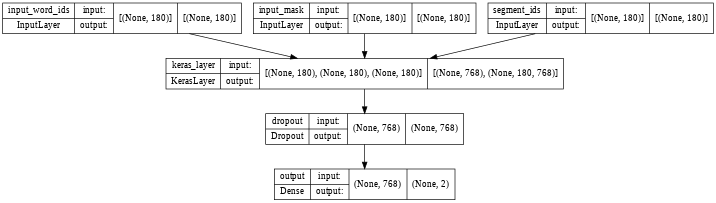

In [ ]:
tf.keras.utils.plot_model(new_model, show_shapes=True, dpi=48)

To check training progress we can use the new and the old testing datasets. Their accuracy should be close. Let's see how it compares.

In [ ]:
loss, accuracy = new_model.evaluate(X_test, dummy_y_test, verbose=False)  # OLD
print("Old testing Accuracy:  {:.4f}".format(accuracy))

loss, accuracy = new_model.evaluate(X_test2, dummy_y_test2, verbose=False)  # NEW
print("New testing Accuracy:  {:.4f}".format(accuracy))

Old testing Accuracy:  0.8282
New testing Accuracy:  0.9188


As you can see there's some difference. In any case, I suggest you use the same testing sample to proceed with you training no matter if the accuracy is the same. This of course applies only to when you do not train on the full dataset.

We need to setup our training parameters again.

In [ ]:
epochs = 3
batch_size = 24  # select based on your GPU resources
eval_batch_size = batch_size

train_data_size = len(dummy_y_train2)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

Now the optimizer we use has learing rate decay in it. Which means learning rate goes down over time by the set parameters. We can lower the initial learning rate for this training session or we could use other optimizer with a fixed learning rate altogether.

In [ ]:
optimizer = nlp.optimization.create_optimizer(
    2e-6, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

Let's compile our model.

In [ ]:
new_model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

And now finally we can train again and see if that helps us achieve a better accuracy.

In [ ]:
history2 = new_model.fit(X_train2,  # using new training set
                         dummy_y_train2,  # using new training set
                         epochs=epochs,
                         batch_size=batch_size,
                         validation_data=(X_test, dummy_y_test),  # using old test dataset
                         verbose=1)

Epoch 1/3
2667/2667 [==============================] - 1632s 606ms/step - loss: 0.2561 - accuracy: 0.8992 - val_loss: 0.4016 - val_accuracy: 0.8422
Epoch 2/3
2667/2667 [==============================] - 1616s 606ms/step - loss: 0.2373 - accuracy: 0.9078 - val_loss: 0.3945 - val_accuracy: 0.8497
Epoch 3/3
2667/2667 [==============================] - 1616s 606ms/step - loss: 0.2269 - accuracy: 0.9124 - val_loss: 0.3833 - val_accuracy: 0.8538


Let's plot everything out.

In [ ]:
for i in history2.history:
  for ele in history2.history[i]:
    history.history[i].append(ele)

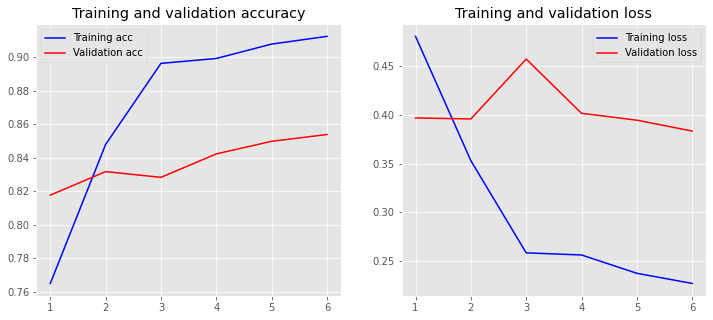

In [ ]:
plot_history(history)

Our lines aren't consistent as we changed the training dataset. However, you can see that both the `val_accuracy` and `val_loss` improved. At his point we could itterate again and improve the model a bit more and more. Just understand that every incrimental improvement will take more data/time as it significantly slows down over time.

In [ ]:
new_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model_fname = 'twitter_BERT_5pct_2'
my_wd = '/content/gdrive/MyDrive/MIAR/TFM/BERT Sentiment/data/'

new_model.save(os.path.join(my_wd, model_fname))

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/MIAR/TFM/BERT Sentiment/data/twitter_BERT_5pct_2/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/MIAR/TFM/BERT Sentiment/data/twitter_BERT_5pct_2/assets


# Is BERT worth it?

So is BERT worth. BERT is a huge model compared to our simple NN and Logistic Regression models we used before. Is the increase in accuracy impactful enough compared to the increase in computation needed? Let's comapre accuracy:


1.   Logistic Regression 0.80
2.   Simple NN           0.79
3.   Finetuned BERT      0.84

In this case it totally depends on you. I personaly would say let's use Logistic Regression. Easily deployable, low computational resources and the task isn't that signicificant in terms of a mistake. If your goal is maximum accuracy possible I would train BERT a bit more and try to get to at least 85%, that would be significant enough to use BERT instead a much less computationaly intesnive Logistic Regression.



# Test

We need to check in with our label encoder to get our classes.

In [ ]:
encoder_fname = 'imdb_classes.npy'
my_wd = '/content/gdrive/MyDrive/MIAR/TFM/BERT Sentiment/data/'

encoder = LabelEncoder()
encoder.classes_ = np.load(os.path.join(my_wd, encoder_fname), allow_pickle=True)

This is how our classes are encoded for the model.

In [ ]:
encoder.classes_

array(['negative', 'positive'], dtype=object)

Input preprocessing.

In [ ]:
tweet = ['Fui a ver la pelicula pensando que era muy mala pero resulto ser una pelicula muy buena. Las actuaciones fueron fascinantes y el guión me encanto']
inputs = bert_encode(string_list=list(tweet), 
                     tokenizer=tokenizerSaved, 
                     max_seq_length=512)

Prediction.

In [ ]:
prediction = model.predict(inputs)
print(prediction)
print('Tweet is', 'positive' if encoder.classes_[np.argmax(prediction)]=='positive' else 'negative')

[[0.25372165 0.74627835]]
Tweet is positive


In [ ]:
inputs

{'input_mask': <tf.Tensor: shape=(1, 180), dtype=int32, numpy=
 array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]], dtype=int32)>,
 'input_type_ids': <tf.Tensor: shape=(1, 180), dtype=int32, numpy=
 array([[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       